## This notebook is to automatically measure real space pixel size for SEND

- We assume au-xgrating sample is being used at low MAG (less than 100 kX) to measure real space pixel size

- We assume 256*256 scans are collected

In [1]:
settings = {
    "data_label": 'bxflow_test/20220920_115349',
    "write_to_file": '1'
}

In [2]:
%matplotlib notebook
import numpy as np
import h5py
import matplotlib.pyplot as plt
import hyperspy.api as hs
import os
from sklearn.neighbors import NearestNeighbors
import pyxem as pxm

In [3]:
path = '/dls/e02/data/2022/cm31101-4/processing/Merlin/'
data_label = settings['data_label']
timestamp = data_label.split('/')[-1]
ibf_path = f'{path}/{data_label}/{timestamp}_ibf.hspy'
meta_path = f'{path}/{data_label}/{timestamp}.hdf'
full_path = f'{path}/{data_label}/{timestamp}_data.hdf5'

In [4]:
timestamp

'20220920_115349'

In [5]:
save_path = os.path.dirname(ibf_path)
print(save_path)

/dls/e02/data/2022/cm31101-4/processing/Merlin//bxflow_test/20220920_115349


In [6]:
im = hs.load(ibf_path)
with h5py.File(meta_path, 'r') as f:
    print(f['metadata'].keys())
    print(f['metadata/magnification'][()])
    mag = f['metadata/magnification'][()]
    print(f['metadata/field_of_view(m)'][()])
    fov = f['metadata/field_of_view(m)'][()]
    sh = f['metadata/4D_shape'][()]

<KeysViewHDF5 ['4D_shape', 'A1_value_(kV)', 'A2_value_(kV)', 'aperture_size', 'convergence_semi-angle(rad)', 'current_OLfine', 'deflector_values', 'defocus(nm)', 'defocus_per_bit(nm)', 'field_of_view(m)', 'ht_value(V)', 'lens_values', 'magnification', 'merlin_camera_length(m)', 'nominal_camera_length(m)', 'nominal_scan_rotation', 'set_bit_depth', 'set_dwell_time(usec)', 'set_scan_px', 'spot_size', 'step_size(m)', 'x_pos(m)', 'x_tilt(deg)', 'y_pos(m)', 'y_tilt(deg)', 'z_pos(m)', 'zero_OLfine']>
60000
3.3333333333333333e-06


In [17]:
mag

60000

In [8]:
def inv_fun(x, a, b):
    """
    x: MAG
    a, b: floats
    
    This function to give an estimate of step size for 256 scans and different MAG's
    """
    return a / x + b
a, b = [7.96153846e+05, 3.46153846e-02]

est_pix = inv_fun(mag, a, b)
est_fov = sh[0] * est_pix
est_square = 500 / est_pix
print(est_square)

lower_b = est_square - 4
upper_b = est_square + 4

37.58311651494817


In [9]:
# Make the functions

from scipy.ndimage import gaussian_filter, maximum_filter

def threshold_image(
    im, 
    thresh, 
    sigma=0, 
    plot_result=False
    ):
    
    if sigma == 0:
        im_sm = im
    else:
        im_sm = gaussian_filter(im,sigma)

    
    im_thresh = (im_sm > thresh).astype('float') * 2 - 1
    
    if plot_result:
        fig,ax = plt.subplots(1,1,figsize=(6,6))
        ax.imshow(im_thresh)
        plt.show()
    
    return im_thresh


def hough_squares(
    im,
    side_lengths = np.arange(50,70,2),
    angle_degrees = np.arange(0,90,2),
    edge_width = 8,
    min_thresh = 0.5,  # relative to maximum filter output
    padding = 64,
    min_dist_maxima = 41,
    plot_result = False,
    return_hough_sig = False,
    ):
    
    # Padding
    im_pad = np.pad(
        im, 
        (0,padding), 
        mode='constant',
        constant_values=0)
    #     im_fft = np.conj(np.fft.fft2(im_pad))
    im_fft = np.fft.fft2(im_pad)
    
    # Coordinates
    x = np.fft.fftfreq(im_pad.shape[0],1/im_pad.shape[0])
    y = np.fft.fftfreq(im_pad.shape[0],1/im_pad.shape[0])
    ya,xa = np.meshgrid(y,x)
    
    # init
    hough_sig = np.zeros_like(im)
    inds_side = np.zeros_like(im, dtype='int')
    inds_angle = np.zeros_like(im, dtype='int')
    #     ds = side_lengths[1] - side_lengths[0]
    
    # Main loop over shapes
    for a0 in range(angle_degrees.shape[0]):
        theta = np.deg2rad(angle_degrees[a0])
        
        xp = xa*np.cos(theta) - ya*np.sin(theta)
        yp = ya*np.cos(theta) + xa*np.sin(theta)
        rp = np.maximum(np.abs(xp), np.abs(yp))
        
        for a1 in range(side_lengths.shape[0]):
            s = side_lengths[a1]
            
            sub1 = rp <= s/2 - edge_width/2
            sub2 = np.logical_and(rp > s/2 - edge_width/2, rp <= s/2 + edge_width/2)
            kernel = np.zeros(im_pad.shape)
            kernel[sub1] = -1*np.sum(sub1)
            kernel[sub2] = np.sum(sub2) 
            
            
            im_corr = np.real(np.fft.ifft2(
                np.fft.fft2(kernel) * im_fft
            ))
            sub_corr = im_corr[:im.shape[0],:im.shape[1]] > hough_sig
            hough_sig[sub_corr] = im_corr[:im.shape[0],:im.shape[1]][sub_corr]
            inds_side[sub_corr] = a1
            inds_angle[sub_corr] = a0
            
    
    # Get the Hough results
    hough_sig /= np.max(hough_sig)
    im_max = np.logical_and.reduce((
        maximum_filter(hough_sig, min_dist_maxima) == hough_sig,
        hough_sig > min_thresh,
        inds_side > 0,
    #         inds_side < side_lengths.shape[0],
    ))
    xy_all = np.argwhere(im_max)
    
    inds = np.ravel_multi_index((xy_all[:,0],xy_all[:,0]),hough_sig.shape)
    sides_all = side_lengths[inds_side[im_max]]
    angles_all = angle_degrees[inds_angle[im_max]]
    hough_data = np.vstack((xy_all.T, sides_all, angles_all)).T
    
    if plot_result:
        fig,ax = plt.subplots(1,1,figsize=(6,6))
        ax.imshow(hough_data)
        plt.show()
    
    if return_hough_sig:
        return hough_data, hough_sig      
    else:
        return hough_data
    
    
def hough_plot_results(
    im,
    hough_data,
    int_range = np.array((-3,3)),
    save_path = None
    ):
    
    im_scale = im - np.mean(im)
    im_scale = im_scale / np.std(im_scale)
    
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    ax.imshow(
        im_scale,
        vmin = int_range[0],
        vmax = int_range[1],
        cmap = 'gray',
    )
    
    b = np.array([
        [0.5,0.5],
        [-0.5,0.5],
        [-0.5,-0.5],
        [0.5,-0.5],
        [0.5,0.5],
    ])
    
    for a0 in range(hough_data.shape[0]):
        x0 = hough_data[a0,0]
        y0 = hough_data[a0,1]
        s = hough_data[a0,2]
        a = np.deg2rad(hough_data[a0,3])
        
        bx = (b[:,0] * np.cos(a) + b[:,1] * np.sin(a)) * s
        by = (b[:,1] * np.cos(a) - b[:,0] * np.sin(a)) * s
        
        
        
        ax.plot(
            by + y0,
            bx + x0,
            c='r',
            linewidth=2,
        )
        ax.plot(y0, x0, 'o')
    
    
    plt.show()
    if save_path is not None:
        plt.savefig(save_path)

<IPython.core.display.Javascript object>


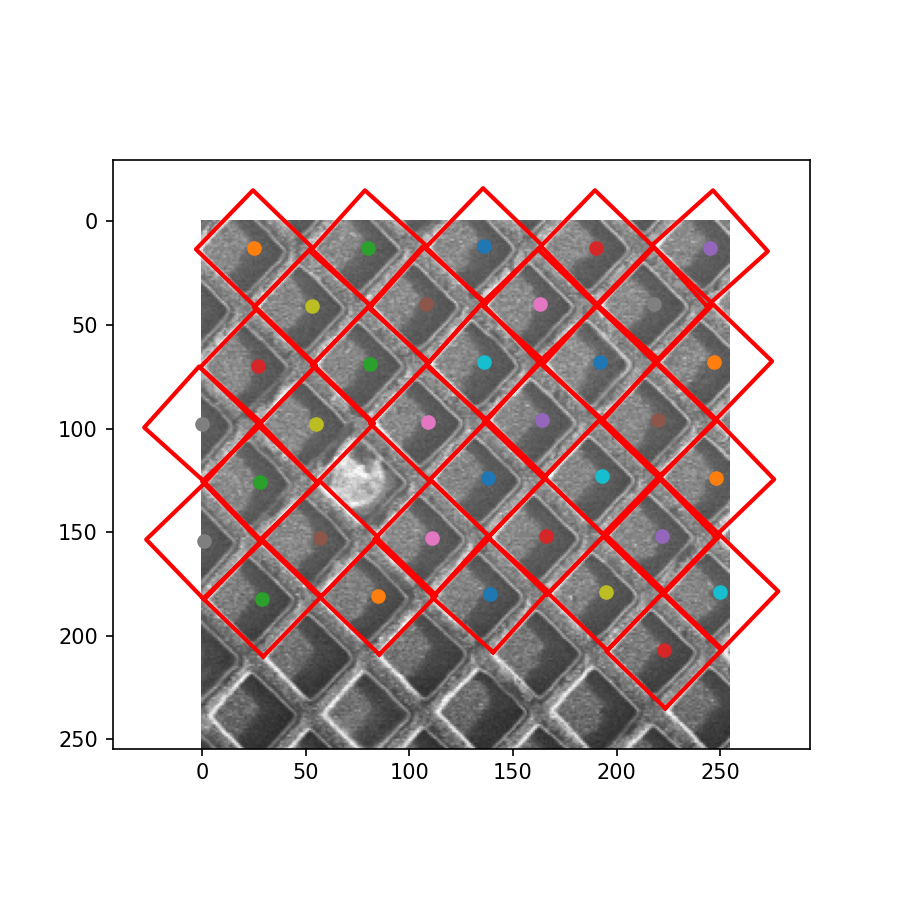

In [10]:
im_thresh = threshold_image(
    im.data, 
    110, 
    sigma=3, 
)

hough_data, hough_sig = hough_squares(
    im_thresh, 
    side_lengths = np.arange(lower_b,upper_b,2),
    return_hough_sig=True
)

hough_plot_results(
    im.data,
    hough_data,
    save_path=os.path.join(os.getcwd(), 'real_space_fit.png')
)

In [11]:
save_path

'/dls/e02/data/2022/cm31101-4/processing/Merlin//bxflow_test/20220920_115349'

In [12]:
X = [[a[0], a[1]] for a in hough_data]

X = [[a[0], a[1]] for a in hough_data]
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

dists = [a[1] for a in distances]
dists = np.asarray(dists)


In [13]:
print(np.mean(dists), np.std(dists))

38.692056497190926 0.4678479082399008


In [14]:
real_pix = 500 / np.mean(dists)
print(real_pix) # in nm

12.92254910349106


In [15]:
base_name = os.path.dirname(save_path)

In [19]:
import json
cal_dict = {}
cal_dict[f'real_space_pix(m)_at_{mag}_MAG'] = real_pix * 1e-9

# Check if write_to_file flag is on if so write to root, otherwise write in cwd

if settings['write_to_file']=='1':
    with open(os.path.join(base_name, f'real_space_cal_at_{mag}_MAG.json'), 'w') as fp:
        json.dump(cal_dict, fp)
    
else:
    with open(os.path.join(os.getcwd(), f'real_space_cal_at_{mag}_MAG.json'), 'w') as fp:
        json.dump(cal_dict, fp)